In [1]:
!pip install imbalanced-learn xgboost


In [3]:
from google.colab import files
uploaded = files.upload()


Saving creditcard.csv to creditcard.csv


In [4]:
import pandas as pd

df = pd.read_csv("creditcard.csv")
print("Shape:", df.shape)
print("Class counts:\n", df['Class'].value_counts())


Shape: (284807, 31)
Class counts:
 Class
0    284315
1       492
Name: count, dtype: int64


In [5]:
df.info()
print("Missing values:", df.isnull().sum().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

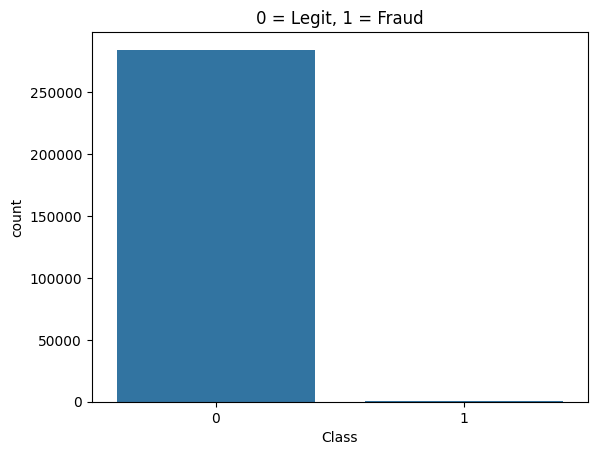

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Class', data=df)
plt.title('0 = Legit, 1 = Fraud')
plt.show()


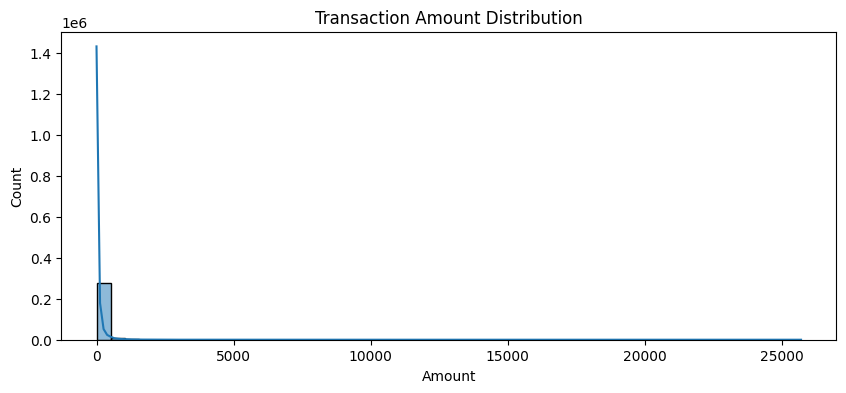

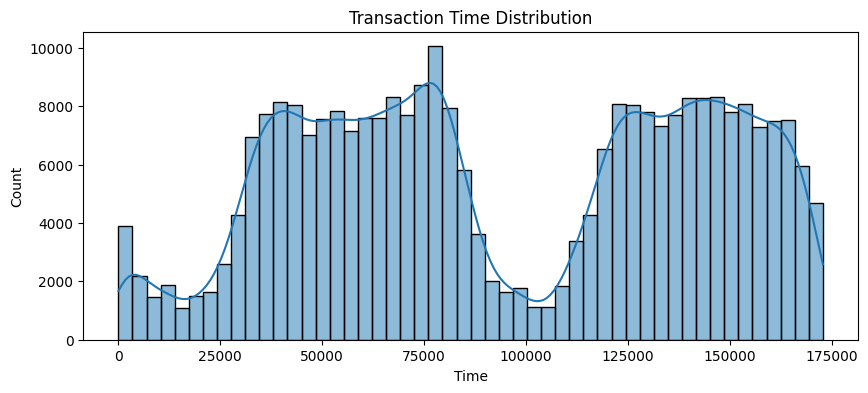

In [7]:
plt.figure(figsize=(10,4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(df['Time'], bins=50, kde=True)
plt.title('Transaction Time Distribution')
plt.show()


In [8]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance dataset
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

print("Before SMOTE:", y.value_counts())
print("After SMOTE:", pd.Series(y_res).value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Before SMOTE: Class
0    284315
1       492
Name: count, dtype: int64
After SMOTE: Class
0    284315
1    284315
Name: count, dtype: int64
Train shape: (454904, 30) Test shape: (113726, 30)


In [9]:
from sklearn.ensemble import RandomForestClassifier
import joblib

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Save model (optional)
joblib.dump(rf, "rf_model.joblib")
print("Model trained and saved")


Model trained and saved


In [10]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9998    0.9999     56863
           1     0.9998    1.0000    0.9999     56863

    accuracy                         0.9999    113726
   macro avg     0.9999    0.9999    0.9999    113726
weighted avg     0.9999    0.9999    0.9999    113726

ROC AUC: 0.9999994065072235
Confusion Matrix:
 [[56849    14]
 [    0 56863]]


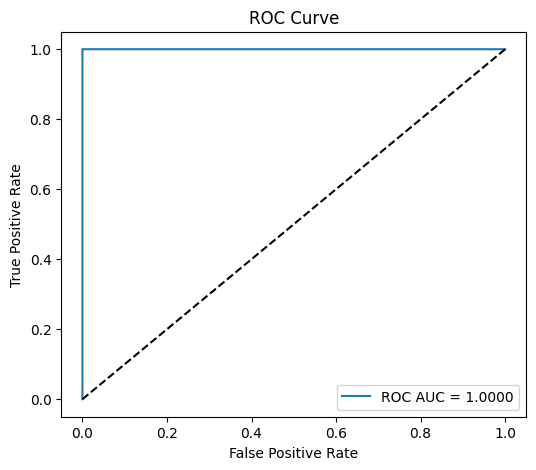

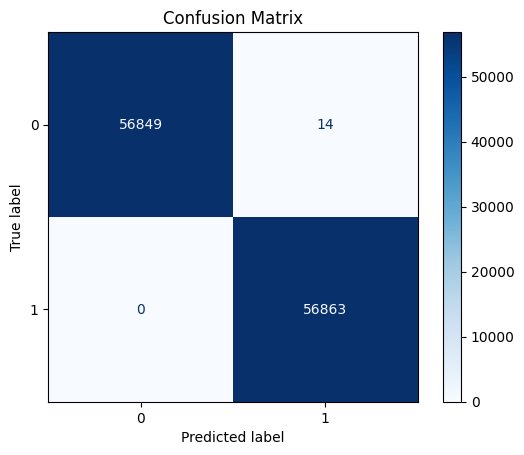

In [11]:
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
